In [1]:
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils.GNN_data import *
from utils.GNN_model import GIN
from utils.train_model import train_model
from utils.evaluate_model import *

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_num', type=int, default=64, help='batch size') 
parser.add_argument('--epoch_num', type=int, default=200, help='Epoch number') 
parser.add_argument('--cover_interval', type=int, default=20, help='Cover interval')
parser.add_argument('--overlap', type=float, default=0.3, help='cover overlap')
parser.add_argument('--save_model_dir', type=str, default='./examples/saved_GNN_model', help='saved GNN model directory')
args = parser.parse_args([])

In [3]:
from torch_geometric.data import Data
import torch 
def load_inp_data(file_path, label):
    nodes, edges = [], []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

        node_section = False
        element_section = False

        for line in lines:
            line = line.strip()

            if "*Node" in line:
                node_section = True
                element_section = False
                continue

            if "*Element" in line:
                node_section = False
                element_section = True
                continue

            # Skip invalid lines like "*Nset" or "*Elset"
            if "*Nset" in line or "*Elset" in line:
                node_section = False
                element_section = False
                continue

            if node_section:
                parts = line.split(',')
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1].strip()), float(parts[2].strip())
                        nodes.append([x, y])
                    except ValueError:
                        continue

            if element_section:
                parts = line.split(',')
                if len(parts) >= 3 and parts[0].strip().isdigit() and parts[1].strip().isdigit() and parts[2].strip().isdigit():
                    start, end = int(parts[1].strip()) - 1, int(parts[2].strip()) - 1  # Convert 1-indexed to 0-indexed
                    
                    if start == end:
                        continue
                    
                    # Ensure indices are within valid range
                    if start < len(nodes) and end < len(nodes):
                        edges.append([start, end])
                    else:
                        print(f"Skipping invalid edge ({start+1}, {end+1}) in {file_path}")

    node_tensor = torch.tensor(nodes, dtype=torch.float)
    edge_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=node_tensor, edge_index=edge_tensor, K=np.float64(label * 200000.00))
    return data

# Data loading

In [4]:
import glob

# Read the Result.txt file and extract filenames and their labels
file_labels = {}
with open('Results.txt', 'r') as file:
    for line in file:
        # Skip empty lines or lines starting with a header
        if line.strip() == "" or "E/Es" in line:
            continue
        
        try:
            file, label = line.strip().split(', ')
            filename, filetype = file.strip().split('.')
            label = float(label)  # Convert the label to a float
            file_labels[filename] = label
        except ValueError:
            print(f"Skipping line due to invalid format: {line.strip()}")

# Load all data points using the filenames and labels from the file_labels dictionary
dataset = [load_inp_data(f"inp_files/{file}.inp", label) for file, label in file_labels.items()]

# Print out the loaded data
for file, label in file_labels.items():
    print(f"Filename: {file}, E/Es: {label}")

Filename: Demi-B10L_R00_n01, E/Es: 0.0158854401415
Filename: Demi-B10L_R01_n01, E/Es: 0.0158742431721
Filename: Demi-B10L_R01_n02, E/Es: 0.015862888844
Filename: Demi-B10L_R01_n03, E/Es: 0.0158529726707
Filename: Demi-B10L_R01_n04, E/Es: 0.0158477450106
Filename: Demi-B10L_R01_n05, E/Es: 0.0158762901241
Filename: Demi-B10L_R01_n06, E/Es: 0.0158681732564
Filename: Demi-B10L_R01_n07, E/Es: 0.0158618711722
Filename: Demi-B10L_R01_n08, E/Es: 0.0158808883496
Filename: Demi-B10L_R01_n09, E/Es: 0.0158723703464
Filename: Demi-B10L_R01_n10, E/Es: 0.0158623548565
Filename: Demi-B10L_R01_n11, E/Es: 0.0158638433144
Filename: Demi-B10L_R01_n12, E/Es: 0.0158923845584
Filename: Demi-B10L_R01_n13, E/Es: 0.0158902640864
Filename: Demi-B10L_R01_n14, E/Es: 0.0158558670376
Filename: Demi-B10L_R01_n15, E/Es: 0.0158854207941
Filename: Demi-B10L_R01_n16, E/Es: 0.0158769272975
Filename: Demi-B10L_R01_n17, E/Es: 0.0158422864719
Filename: Demi-B10L_R01_n18, E/Es: 0.0158808457854
Filename: Demi-B10L_R01_n19, E/E

In [5]:
dataset

[Data(x=[128, 2], edge_index=[2, 288], K=3177.0880283),
 Data(x=[128, 2], edge_index=[2, 288], K=3174.84863442),
 Data(x=[128, 2], edge_index=[2, 288], K=3172.5777688000003),
 Data(x=[128, 2], edge_index=[2, 288], K=3170.5945341399997),
 Data(x=[128, 2], edge_index=[2, 288], K=3169.54900212),
 Data(x=[128, 2], edge_index=[2, 288], K=3175.2580248199997),
 Data(x=[128, 2], edge_index=[2, 288], K=3173.63465128),
 Data(x=[128, 2], edge_index=[2, 288], K=3172.3742344400002),
 Data(x=[128, 2], edge_index=[2, 288], K=3176.17766992),
 Data(x=[128, 2], edge_index=[2, 288], K=3174.4740692799996),
 Data(x=[128, 2], edge_index=[2, 288], K=3172.4709713),
 Data(x=[128, 2], edge_index=[2, 288], K=3172.76866288),
 Data(x=[128, 2], edge_index=[2, 288], K=3178.47691168),
 Data(x=[128, 2], edge_index=[2, 288], K=3178.05281728),
 Data(x=[128, 2], edge_index=[2, 288], K=3171.1734075199997),
 Data(x=[128, 2], edge_index=[2, 288], K=3177.0841588199996),
 Data(x=[128, 2], edge_index=[2, 288], K=3175.3854595),

In [6]:
dataset = feature_engineering(dataset)

In [7]:
batch_size = args.batch_num
epoch_num = args.epoch_num 
learning_rate = 0.001
overlap=args.overlap

# Check if the graph data is directed or undirected. For this study, undirected edges are used.
all_undirected_before = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (before conversion): {all_undirected_before}')  # True if all are undirected, False otherwise

# Convert all graphs in the dataset to undirected
dataset = [make_undirected(data) for data in dataset]

# Re-check if all graphs are now undirected
all_undirected_after = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (after conversion): {all_undirected_after}')  # True if all are undirected, False otherwise

dataset = normalize_planar_info(dataset)

# Split dataset for train/validation/test
train_loader, test_loader, valid_loader = prepare_dataset(dataset, batch_size, train_percentage=0.80, test_percentage=0.1)

Graphs are undirected (before conversion): False
Graphs are undirected (after conversion): True
Number of training graphs: 800
Number of test graphs: 100
Number of vali graphs: 101


In [8]:
dataset[0].x

tensor([[0.0000, 0.0767, 0.9868, 0.3333, 0.5506, 1.0000],
        [0.0000, 0.3186, 0.7663, 0.3333, 0.5506, 1.0000],
        [0.0000, 0.5605, 0.7141, 0.3333, 0.6229, 0.3000],
        [0.0000, 0.8024, 0.8613, 0.3333, 0.6524, 1.0000],
        [0.0372, 0.1976, 0.8186, 0.5000, 0.7009, 0.3000],
        [0.0372, 0.4395, 0.6620, 0.5000, 0.7403, 0.3000],
        [0.0372, 0.6814, 0.7180, 0.5000, 0.6793, 1.0000],
        [0.0372, 0.9233, 0.9497, 0.5000, 0.7603, 0.3000],
        [0.0881, 0.0324, 0.9577, 0.3333, 0.7459, 0.3000],
        [0.0881, 0.1209, 0.8480, 0.8333, 0.6082, 1.0000],
        [0.0881, 0.2743, 0.6886, 0.8333, 0.6911, 0.3000],
        [0.0881, 0.3628, 0.6239, 0.8333, 0.6397, 0.3000],
        [0.0881, 0.5162, 0.5833, 0.8333, 0.6335, 0.6667],
        [0.0881, 0.6047, 0.6071, 0.8333, 0.7001, 0.4000],
        [0.0881, 0.7581, 0.7180, 0.8333, 0.7136, 0.6667],
        [0.0881, 0.8466, 0.8105, 0.8333, 0.8068, 0.4000],
        [0.0881, 1.0000, 1.0000, 0.5000, 0.6848, 0.6667],
        [0.139

# GNN architecture

In [9]:
# Define the model, optimizer, and loss function

no_node_feature = dataset[0].x.shape[1]
model = GIN(dim_h=128, node_feature=no_node_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=384, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin4): Linear

/root/miniconda3/envs/GNN_ElasticModulus_Prediction/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

In [10]:
train_losses, test_losses, R2_trainings, R2_tests, best_state_dict = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device=device, num_epochs=epoch_num)

Epoch [1], Loss[Train: 4428734.940, Test: 4529617.560], R2[Train: -24.985, Test: -31.601]
Epoch [2], Loss[Train: 964008.575, Test: 132967.832], R2[Train: -4.656, Test: 0.043]
Epoch [3], Loss[Train: 199128.330, Test: 184169.078], R2[Train: -0.168, Test: -0.326]
Epoch [4], Loss[Train: 163596.279, Test: 134146.400], R2[Train: 0.040, Test: 0.035]
Epoch [5], Loss[Train: 171907.186, Test: 121896.089], R2[Train: -0.009, Test: 0.123]
Epoch [6], Loss[Train: 161160.064, Test: 148736.801], R2[Train: 0.054, Test: -0.071]
Epoch [7], Loss[Train: 152107.539, Test: 162157.539], R2[Train: 0.108, Test: -0.167]
Epoch [8], Loss[Train: 150233.150, Test: 128764.122], R2[Train: 0.119, Test: 0.073]
Epoch [9], Loss[Train: 132338.707, Test: 116065.965], R2[Train: 0.224, Test: 0.165]
Epoch [10], Loss[Train: 148355.761, Test: 170710.236], R2[Train: 0.130, Test: -0.229]
Epoch [11], Loss[Train: 242690.644, Test: 173138.950], R2[Train: -0.424, Test: -0.246]
Epoch [12], Loss[Train: 140730.198, Test: 95807.750], R2[Tr

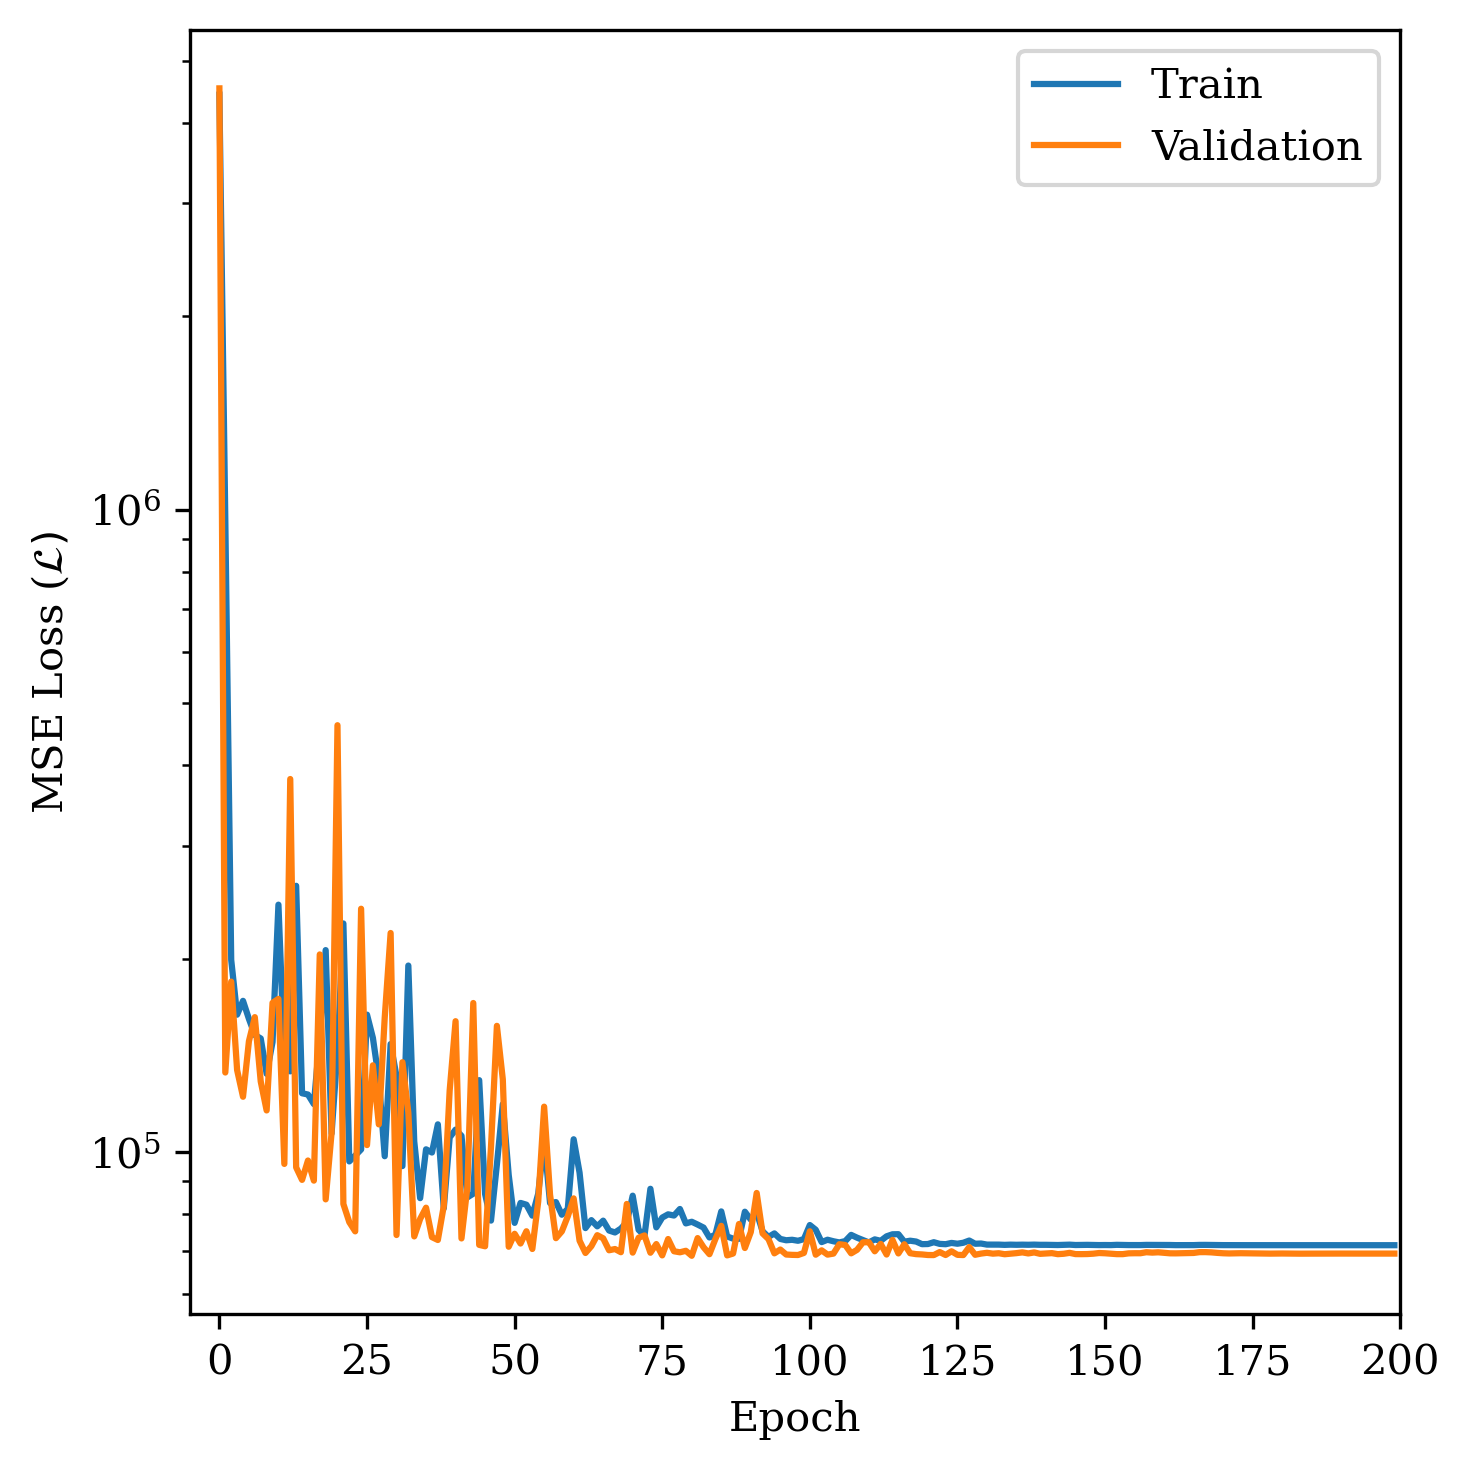

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Epoch vs R^2
plt.figure(dpi=300, figsize=(5,5)) 

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 10

plt.plot(np.array(train_losses), label='Train')
plt.plot(np.array(test_losses), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'MSE Loss ($\mathcal{L})$')
plt.yscale("log") 
plt.xlim(-5,epoch_num)
plt.tight_layout() 

# Save model

In [12]:
best_model_path = f'{args.save_model_dir}/epoch_{args.epoch_num}.pt'  
torch.save(best_state_dict, best_model_path)

# Evaluation

Test R2 for E: 0.579974889755249


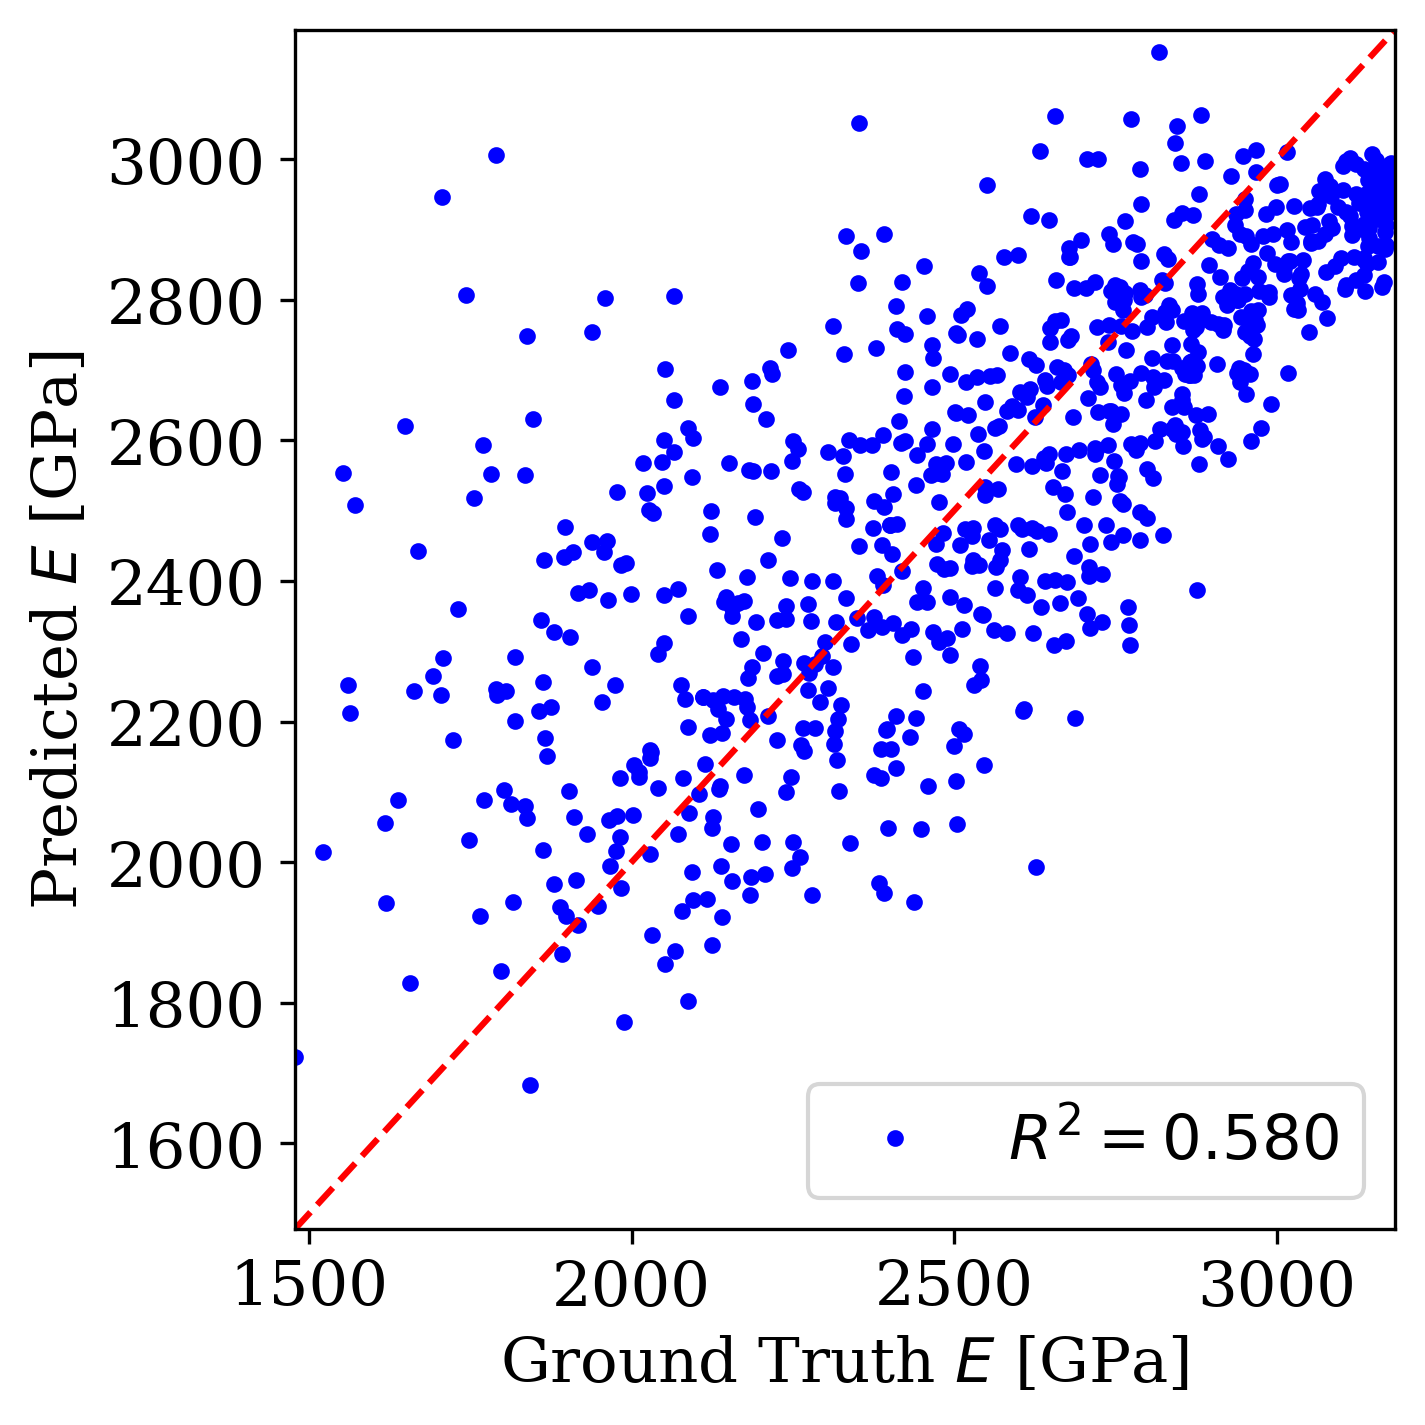

In [13]:
R2_K = evaluate_model(model, train_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.5000205039978027


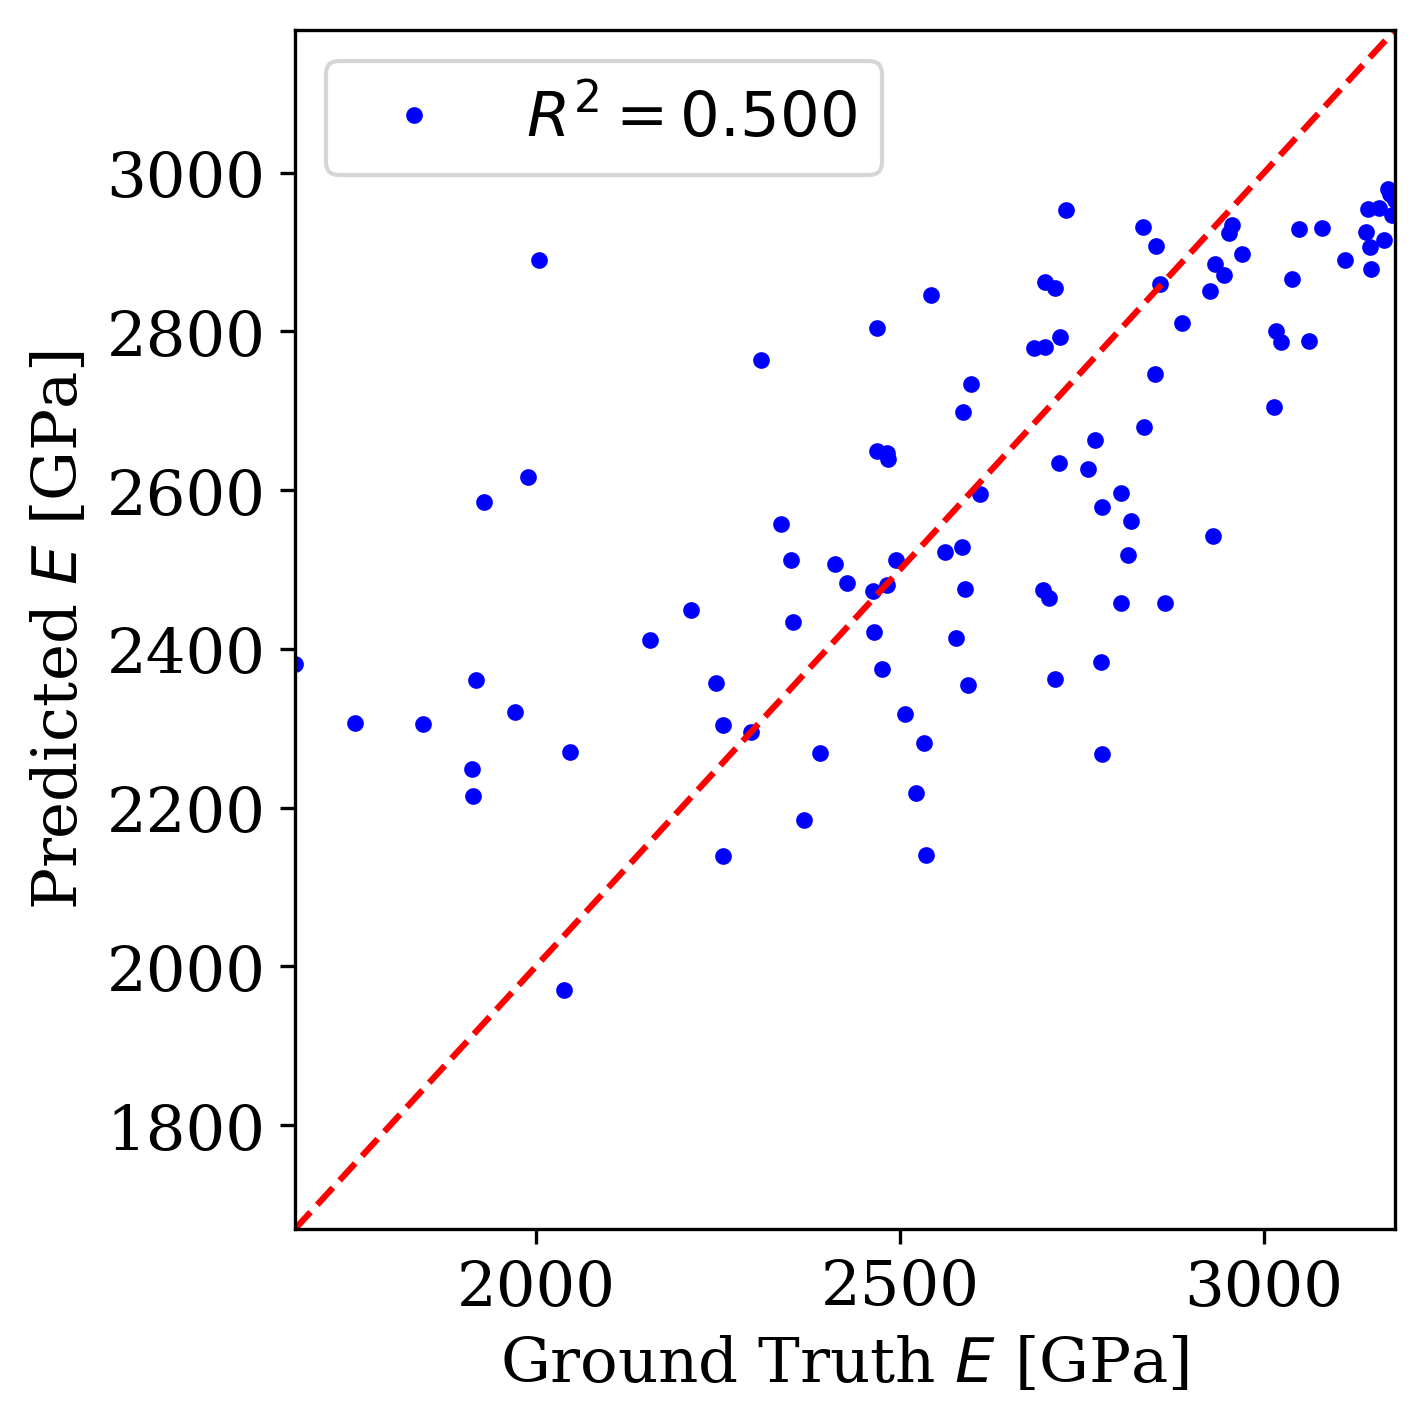

In [14]:
R2_K = evaluate_model(model, test_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.4393528699874878


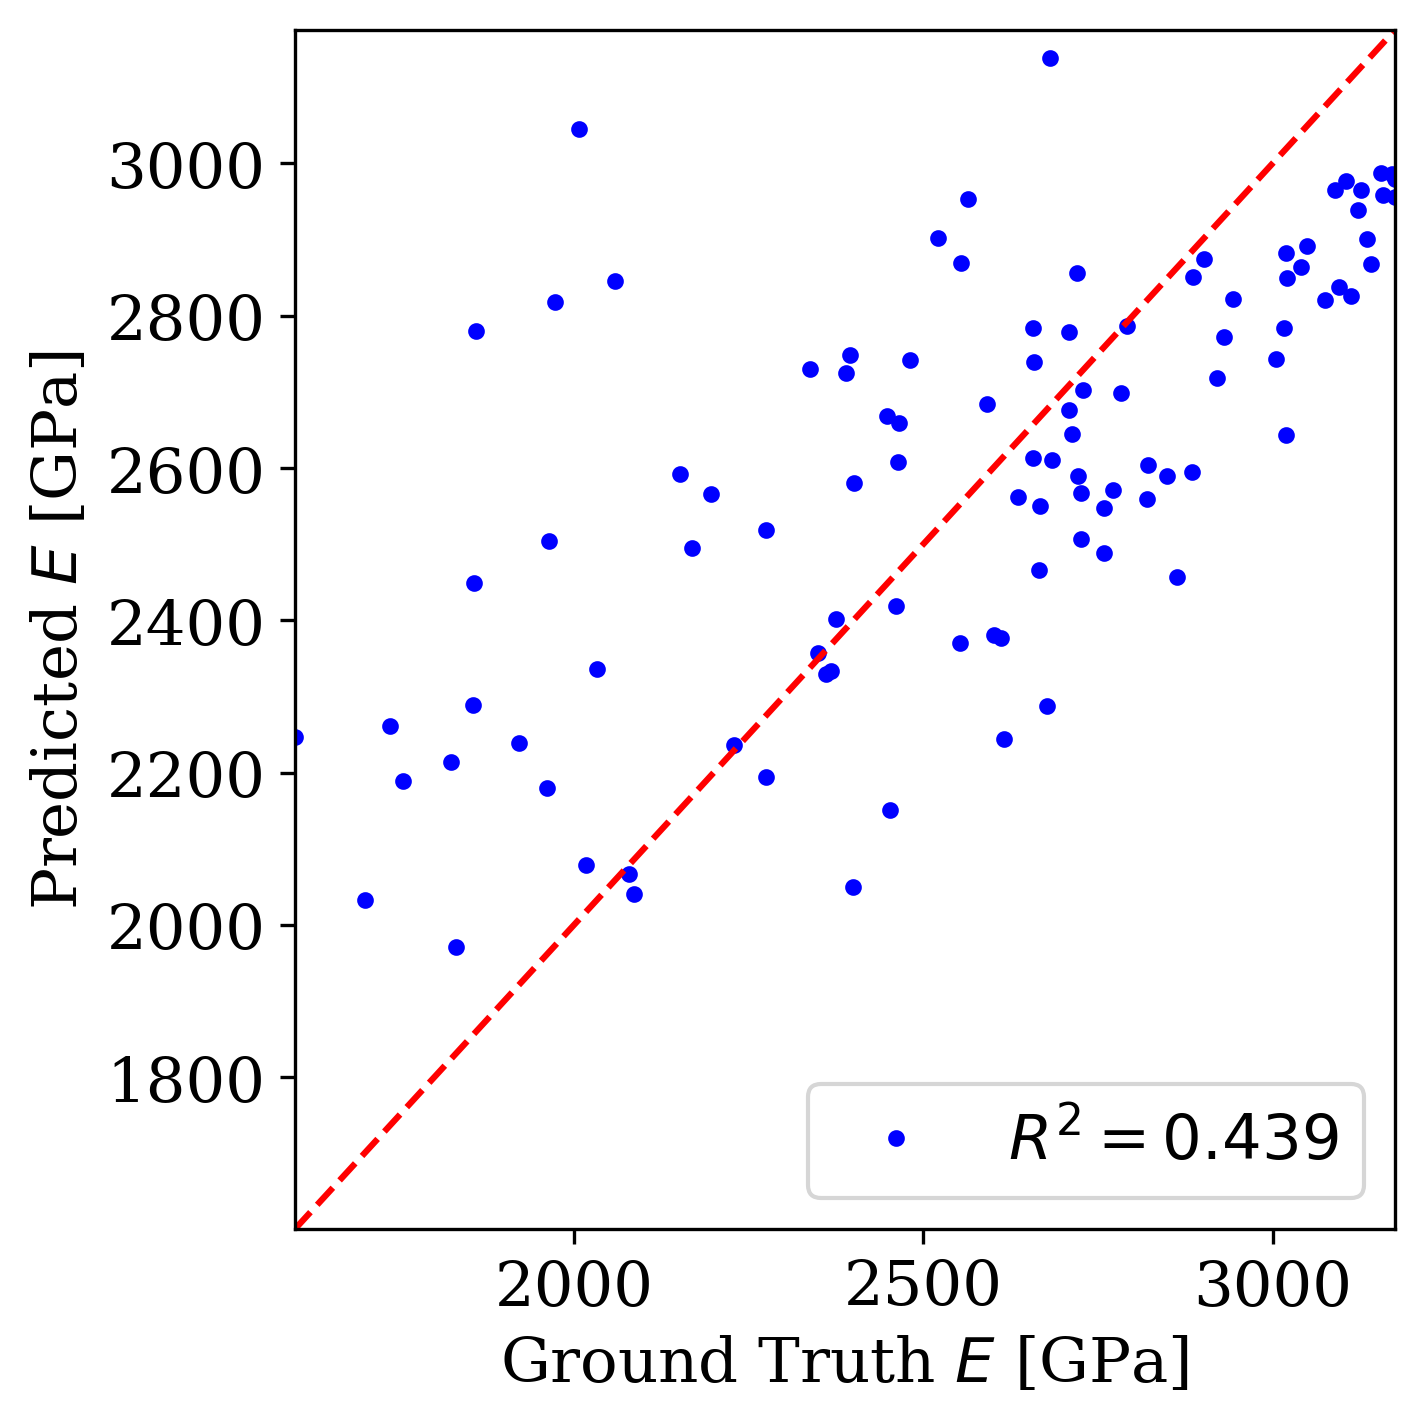

In [15]:
R2_K = evaluate_model(model, valid_loader, device, args.cover_interval, overlap, args.save_model_dir)